<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/Audio_Classification_Using_CNNs/blob/master/Audio_Classification_Using_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Classification Using CNNs**

**Download the dataset from the below link**

[Data](https://drive.google.com/drive/folders/1YuzRUYVXOscxmsvQSffU8cBoBdDGnlrq?usp=sharing)

you can also use the below code to get the dataset automatically

In [ ]:
import subprocess
!gdown '1cQ4qs39v702V1tqqod7R5BTR7p6ynanM' # background
!unzip background-20241226T195006Z-001.zip
!gdown '1Tejyt1WoO2sMh3ICvDyoi3yoZxwtfc1K' # chainsaw
!unzip chainsaw-20241226T195102Z-001.zip
!gdown '1q5xcI4I5FjrpuHOgiLO5_Iz734DR1fg0' # engine
!unzip engine-20241226T195159Z-001.zip
!gdown '11uQmOJRtkcOI1kwl_YCmmHeUed8nt7FD' # storm
!unzip storm-20241226T195309Z-001.zip
!gdown '1j6X6dbWIYIpturPAYRTE6JLQYlex2vOK' # test
!unzip test_data-20241226T195424Z-001.zip
!mkdir 'train_data'
bash1 = "for file in ./background/*;do mv $file 'train_data';done"
bash2 = "for file in ./chainsaw/*;do mv $file 'train_data';done"
bash3 = "for file in ./engine/*;do mv $file 'train_data';done"
bash4 = "for file in ./storm/*;do mv $file 'train_data';done"
subprocess.run(bash1, shell=True, check=True)
subprocess.run(bash2, shell=True, check=True)
subprocess.run(bash3, shell=True, check=True)
subprocess.run(bash4, shell=True, check=True)

Audio classification can be performed by converting audio streams into spectrograms, which provide visual representations of spectrums of frequencies as they vary over time, and classifying the spectrograms using convolutional neural networks (CNNs). The spectrograms below were generated from WAV files with chainsaw sounds in the foreground and rainforest sounds in the background. Let's use Keras to build a CNN that can identify the tell-tale sounds of logging operations and distinguish them from ambient sounds such as wildlife and thunderstorms.

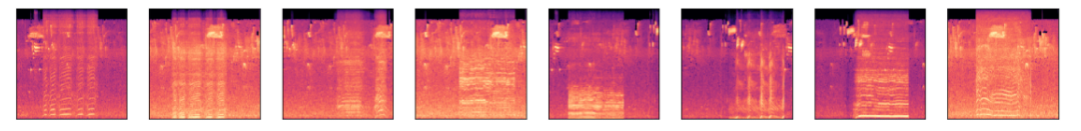

## **Generate Spectrogram**



The "Sounds" directory contains subdirectories named "background," "chainsaw," "engine," and "storm." Each subdirectory contains 100 WAV files. The WAV files in the "background" directory contain rainforest background noises only, while the files in the other subdirectories include the sounds of chainsaws, engines, and thunderstorms overlaid on the background noises. These WAV files were generated by using a soundscape-synthesis package named Scaper to combine sounds in the public UrbanSound8K dataset with rainforest sounds obtained from YouTube.

The first step is to load the WAV files, use a Python package named Librosa to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [ ]:
## Just Run the below code-block

import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def spectrogram_creation(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def save_spectograms(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        spectrogram_creation(input_file, output_file)

In [ ]:
## Complected...Done!
## in this cell call the above functions for creating spectrograms for every class of waves.

import os

input_root = 'dataset/audio'           # Path to the folder containing the .wav files for each class
output_root = 'dataset/spectrograms'   # Destination path to save .png images

classes = ['background', 'chainsaw', 'engine', 'storm']

for cls in classes:
    input_path = os.path.join(input_root, cls)
    output_path = os.path.join(output_root, cls)
    save_spectograms(input_path, output_path)

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [ ]:
## Complected...Done!

from tensorflow.keras.preprocessing import image
import numpy as np

def loading_spectrograms(path, label):
    '''
    This function is used for loading images from their root path provided.
    During this process, resize images to 224*224 by setting the target size in loading function.
    Then convert them to tensor and finally append them to a corresponding list.
    Hint:
      https://docs.w3cub.com/tensorflow~python/tf/keras/preprocessing/image/load_img
      https://docs.w3cub.com/tensorflow~2.3/keras/preprocessing/image/img_to_array
    Arguments:
      path: path to the .png files of the label class
      label: a specific class of sounds
    return:
      images: png files converted to the tensor
      labels: label of the class corresponding to the images
    '''
    '''
    This function loads all .png images from the given path,
    resizes them to 224x224, converts them to tensors, and assigns the given label.

    Arguments:
      path: Path to the .png files of the label class (e.g., 'dataset/spectrograms/chainsaw')
      label: Integer label corresponding to the class (e.g., 1 for chainsaw)

    Returns:
      images: List of image tensors (numpy arrays)
      labels: List of integer labels corresponding to the images
    '''

    images = []
    labels = []

    for file in os.listdir(path):
        if file.endswith('.png'):
            img_path = os.path.join(path, file)
            img = image.load_img(img_path, target_size=(224, 224))  # Resize image
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(label)

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x = [] # list of training images for CNN
y = [] # list of corresponding labels to the images

In [ ]:
## Load each directory's images and label

class_mapping = {
    'background': 0,
    'chainsaw': 1,
    'engine': 2,
    'storm': 3
}

spectrogram_root = 'dataset/spectrograms'

for class_name, label in class_mapping.items():
    class_path = os.path.join(spectrogram_root, class_name)
    images, labels = loading_spectrograms(class_path, label)

    x.extend(images)
    y.extend(labels)

# Show a sample of loaded images
show_images(x)

Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [ ]:
## because your data is in list, convert them to np.array

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

# Split into training and test sets (e.g., 80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Normalize pixel values
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

## **Build and train a CNN**

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a softmax layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN.

Build below network

Model: "sequential"

Layer (type)                 Output Shape              #Param
-----------------------------------------------------------------
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100   

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()

# Layer 1: Conv2D + MaxPool
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Conv2D + MaxPool
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Conv2D + MaxPool
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Conv2D + MaxPool
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Fully Connected Dense Layers
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Train the CNN and save the history object returned by fit in a local variable.

In [ ]:
##############################################
############# YOUR CODES GO HERE #############
hist = ...
##############################################

Plot the training and validation accuracy.

In [ ]:
##############################################
############# YOUR CODES GO HERE #############
acc = ...
val_acc = ...
##############################################
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run the test images through the network and use a confusion matrix to assess the results.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

##############################################
############# YOUR CODES GO HERE #############
y_predicted = ....
mat = confusion_matrix(..., ...)
##############################################

class_labels = ['background', 'chainsaw', 'engine', 'storm']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')